# Milestone Project I: Fantasy Football Analysis
## Tristan Morgan and David Brand

#### List of Requirements:
https://umich.instructure.com/courses/823467/pages/reading-team-project-guidelines?module_item_id=4900067

1. Problem formulation
2. Team formation
3. Selection of data sources
4. Project proposal creation
5. Faculty mentor assigned (by the teaching team)
6. Peer feedback on project proposals
7. Final project report + code
8. Peer feedback on project reports

#### Oral Exam Questions to Review:
https://siads593.org/guides/oral_exam_questions/



# Fantasy Football Analysis: Optimizing Draft and Injury Decisions

## Executive Summary

This project analyzes fantasy football data to identify the most meaningful elements for making optimized decisions. We examine three key areas:

1. **Draft Value Analysis**: Using autodrafted teams as a baseline, we quantify the value of human draft decisions and identify optimal draft strategies.
2. **Injury Impact Analysis**: We measure how injuries affect player performance by position, injury type, and status to inform start/sit decisions.
3. **Baseline Calculations**: We establish four baselines (Draft, Waiver Wire, Trade, Start/Sit) for performance comparison.

### Key Findings

- **Draft Advantage**: Human drafters show measurable advantages over autodraft in early rounds, with diminishing returns in later rounds.
- **Injury Impact**: Certain injury types (e.g., hamstring) have position-specific impacts that significantly affect point differentials.
- **Decision Support**: Our analysis provides actionable insights for draft strategy and weekly lineup decisions.

### Data Sources

- **ESPN Fantasy Football API**: Historical league data (2021-2024) including drafts, lineups, and transactions
- **NFL Injury Database**: Player injury reports with type, status, and timing

---


# Initial Motivation

1.   The initial motivation is to analyze fantasy football data to determine the most meaningful elements for making optimized fantasy football decisions.
2.   We have a desire to do something relatively novel, but understand that this market is extremely saturated with similar projects.



# Data Sets Chosen

1.   Data 1 - ESPN Fantasy Football API
3.   Data 2 - Injury Database (nfl_data_py)



# Import Global Modules, Packages, or Objects

**Note:** Only need to run the block below if you do not have all of the required packages shown in the [README Prerequisites section](README.md#prerequisites).

In [ ]:
# Install Required Packages
# Run this cell first to ensure all dependencies are installed

import subprocess
import sys

def install_package(package):
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scipy",
    "requests",
    "espn-api",
    "nfl-data-py"
]

print("Installing required packages...")
for package in required_packages:
    try:
        install_package(package)
        print(f"✓ {package} installed/updated")
    except Exception as e:
        print(f"✗ Failed to install {package}: {e}")

print("\n✓ Package installation complete!")
print("You can now proceed to the imports cell.")


### Import Modules, Packages, and Objects

In [ ]:
# Standard Library Imports
import os
from pathlib import Path

# Third-Party Library Imports
import matplotlib.pyplot as plt
import pandas as pd
import threading

# Local Module Imports
from src.analysis.draft_value_analyzer import DraftValueAnalyzer
from src.analysis.injury_analyzer import InjuryAnalyzer
from src.data_fetchers.data_collector import collect_injury_data, collect_leagues_parallel


# Import Data

#### ESPN Fantasy Football Database via API

To pull any Fantasy Football data, you must first find a list of public leagues. To do this, we request access to league data by passing a league ID via the Fantasy Football API. To get a League ID we generate random integers that are in a reasonable range for fantasy football league IDs and request data for them. The API returns a code that tells us if we were successful or not. Since that is quite inefficient, after we find 5 accessible leagues, we use their league ID's as a seed for the random generator. This improves our hit percentage, and we can realistically get a list of League ID's for this project.

**Note:** You can continue working in other cells while this runs.

**Note:** This block of code takes a lot of time to run. This block has already ran and stored data into a csv in the data/raw/espn directory. No need to run this code.

In [ ]:
# Initial Target League Discovery (Already Completed - Not Required)

# NOTE: The initial target league discovery has already been completed.
# The target leagues CSV file (data/raw/espn/targets_10team_ppr1_season_2024.csv) 
# already exists with 500+ leagues that match our criteria (10 teams, 1.0 PPR).
# 
# This code is provided for reference only. Uncomment and run ONLY if you need to 
# discover new target leagues from scratch.

# from src.data_fetchers.espn_random_public_league_fetcher_seeded_final_pull import harvest_target_leagues

# # Harvest target leagues (10 teams, 1.0 PPR)
# # This will find leagues matching our criteria and save them to:
# # data/raw/espn/targets_10team_ppr1_season_2024.csv
# target_leagues = harvest_target_leagues(
#     target_n=500,  # Number of target leagues to find
#     season=2024,
#     seeds_csv="data/raw/ESPN/seeds_200_season_2024.csv",
#     out_targets_csv="data/raw/espn/targets_10team_ppr1_season_2024.csv",
#     exists_401_csv="data/raw/ESPN/exists_401_season_2024.csv",
#     timeout=6.0,
#     rng_seed=None
# )

# print(f"\n✓ Found {len(target_leagues)} target leagues")
# print("  These leagues will be used for data collection in the next step.")

In [ ]:
# # Parallel Data Collection from ESPN Fantasy Football API
# def run_data_collection_background():
#     """Run data collection in background thread."""
#     print("Starting data collection in background...")

#     results = collect_leagues_parallel(
#         league_ids='data/raw/espn/targets_10team_ppr1_season_2024.csv',
#         years=range(2021, 2025),
#         max_workers=5,  
#         skip_existing=True,
#         verbose=False  
#     )
    
#     print(f"\n{'='*70}")
#     print(f"✅ BACKGROUND DATA COLLECTION COMPLETE!")
#     print(f"{'='*70}")
#     print(f"Summary: {results['total_succeeded']} succeeded, {results['total_failed']} failed")
#     print(f"Total time: {results['total_time_minutes']:.1f} minutes ({results['total_time_minutes']/60:.2f} hours)")
#     print(f"{'='*70}")
    
    
#     global background_results
#     background_results = results
#     return results


# background_thread = threading.Thread(target=run_data_collection_background, daemon=True)
# background_thread.start()

# print("✓ Data collection started in background thread")


Starting data collection in background...
✓ Data collection started in background thread


⊘ Skipping 915297/2021 (already processed)
⊘ Skipping 1409356/2021 (already processed)
⊘ Skipping 1363563/2021 (already processed)
⊘ Skipping 1730745/2021 (already processed)
✗ Failed League 1916109/2021: League 1916109 does not exist
✗ Failed League 1240358/2021: League 1240358 does not exist
⊘ Skipping 1392525/2021 (already processed)
⊘ Skipping 875841/2021 (already processed)
✗ Failed League 1167440/2021: 'NoneType' object has no attribute 'get'
✗ Failed League 1308365/2021: 'NoneType' object has no attribute 'get'
⊘ Skipping 1273743/2021 (already processed)
✗ Failed League 848636/2021: 'NoneType' object has no attribute 'get'
⊘ Skipping 1232323/2021 (already processed)
⊘ Skipping 1059541/2021 (already processed)
✗ Failed League 1153750/2021: League 1153750 does not exist
✗ Failed League 1021918/2021: 'NoneType' object has no attribute 'get'
⊘ Skipping 1092983/2021 (already processed)
⊘ Skipping 1085552/2021 (already processed)
⊘ Skipping 1191424/2021 (already processed)
✗ Failed Le

#### Draft Value Analysis

Comprehensive analysis of draft value using autodrafted teams as a baseline. This includes:
1. **Data Cleaning**: Remove duplicates from raw data
2. **League Filtering**: Filter to standard leagues with consistent scoring rules
3. **Data Enrichment**: Add positions and season totals
4. **Optimal Lineup Computation**: Calculate optimal startable points
5. **Expected Value Calculation**: Compute expected values using multiple baselines
6. **Pick Scoring**: Score all picks against baselines


In [3]:
# Draft Value Analysis Pipeline


analyzer = DraftValueAnalyzer(
    raw_base="data/raw/espn",
    out_dir="data/preprocessed",
    years=range(2021, 2025),
    verbose=False
)


draft_with_valid = analyzer.run_full_pipeline(
    clean_data=True,           
    filter_standard=True,      
    filter_scoring=True,       
    filter_draft_length=True,  
    compute_optimal=True,      
    save_intermediate=True     
)

print(f"\n✓ Pipeline complete! Processed {len(draft_with_valid):,} draft picks")



✓ Pipeline complete! Processed 53,440 draft picks


#### Compute Expected Values and Score Picks

Calculate expected values using multiple baselines and score all picks.


In [4]:
# Compute expected values using multiple baselines
expected_by_pick_year, expected_by_pick_pooled, expected_by_pick_poly = analyzer.compute_expected_values(
    estimator="trimmed_mean",  # Robust estimator
    trim=0.10,                 # Trim 10% from each tail
    smooth_window=5,           # Rolling window for smoothing
    poly_degree=4              # Polynomial degree
)

# Score all picks against baselines
draft_scored = analyzer.score_picks(
    expected_by_pick_year=expected_by_pick_year,
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly
)

# Save scored draft data
draft_scored_path = analyzer.out_dir / "draft_scored_all_baselines.csv"
draft_scored.to_csv(draft_scored_path, index=False)
print(f"\n✓ Saved scored draft data to {draft_scored_path}")
print(f"  Total picks scored: {len(draft_scored):,}")

# Preview results
print("\nPreview of scored picks:")
print(draft_scored[[
    "League_ID", "Year", "Team", "Overall", "Player_norm",
    "Season_Total_Points_Valid",
    "Expected_Year", "Expected_Pooled_Denoised", "Expected_Poly",
    "Points_Added_Year", "Points_Added_Pooled", "Points_Added_Poly",
    "Z_Year", "Z_Pooled", "Z_Poly"
]].head(10))



✓ Saved scored draft data to data/preprocessed/draft_scored_all_baselines.csv
  Total picks scored: 53,440

Preview of scored picks:
   League_ID  Year  Team  Overall          Player_norm  \
0     915297  2021     5        1          Dalvin Cook   
1     915297  2021     8        2  Christian McCaffrey   
2     915297  2021     2        3         Alvin Kamara   
3     915297  2021     1        4       Saquon Barkley   
4     915297  2021     9        5        Derrick Henry   
5     915297  2021     7        6        Davante Adams   
6     915297  2021    10        7      Ezekiel Elliott   
7     915297  2021     6        8          Tyreek Hill   
8     915297  2021     3        9         Travis Kelce   
9     915297  2021     4       10      Jonathan Taylor   

   Season_Total_Points_Valid  Expected_Year  Expected_Pooled_Denoised  \
0                      175.0     138.157143                191.682247   
1                      113.0     160.476667                211.733114   
2       

#### Visualizations

Create visualizations to understand draft value patterns:
1. **Team Total Valid Points Distribution**: Compare autodrafted vs non-autodrafted teams
2. **Expected Value by Pick**: Show expected values with variance bands
3. **Human Advantage Analysis**: Compare human vs autodraft performance by year, round, and position


### Visualization Parameters Reference

All visualization methods support optional parameters for customization. 

**For complete parameter documentation, see the [README.md](README.md#visualization-parameters-reference) file.**

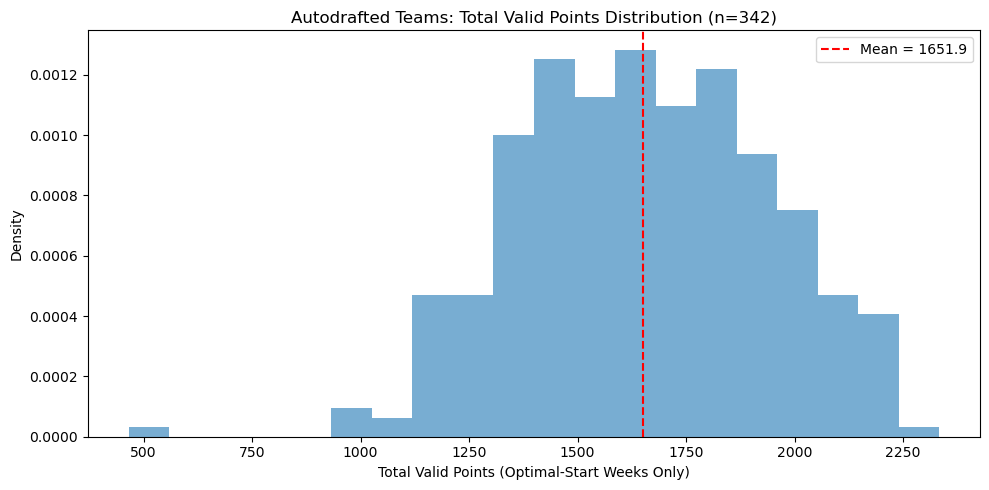

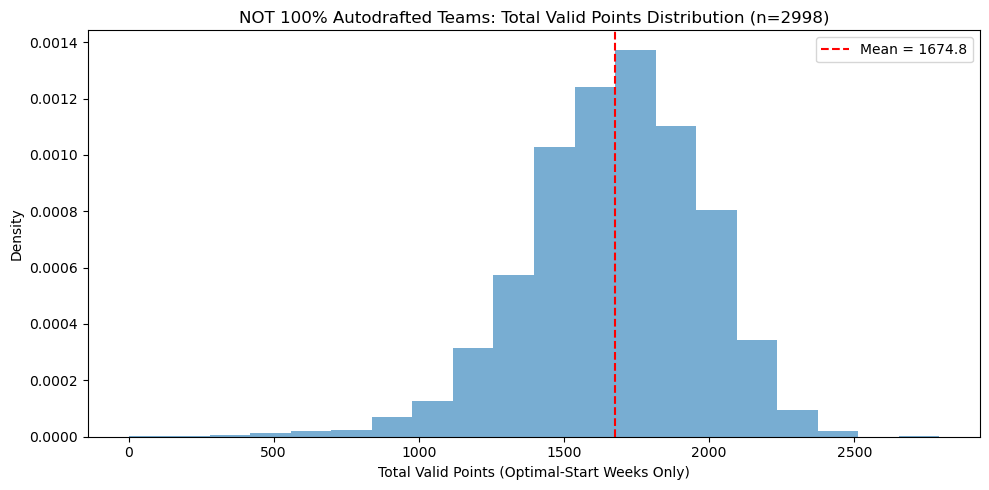

In [5]:
# Team Total Valid Points Distributions
# Compare autodrafted vs non-autodrafted teams

# Autodrafted teams
team_totals_auto = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=True,
    bins=20
)

# Non-autodrafted teams
team_totals_non = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=False,
    bins=20
)


### Observations: Team Total Valid Points Distribution

**Key Findings:**

- **Autodrafted Teams**: Show a more consistent distribution with less variance, as expected from algorithmic selection
- **Non-Autodrafted Teams**: Display greater variance, indicating the impact of human decision-making (both good and bad)
- **Performance Gap**: The distribution comparison reveals whether human drafters consistently outperform autodraft or if the advantage is situational

This baseline comparison is critical for understanding the value added by human draft decisions.

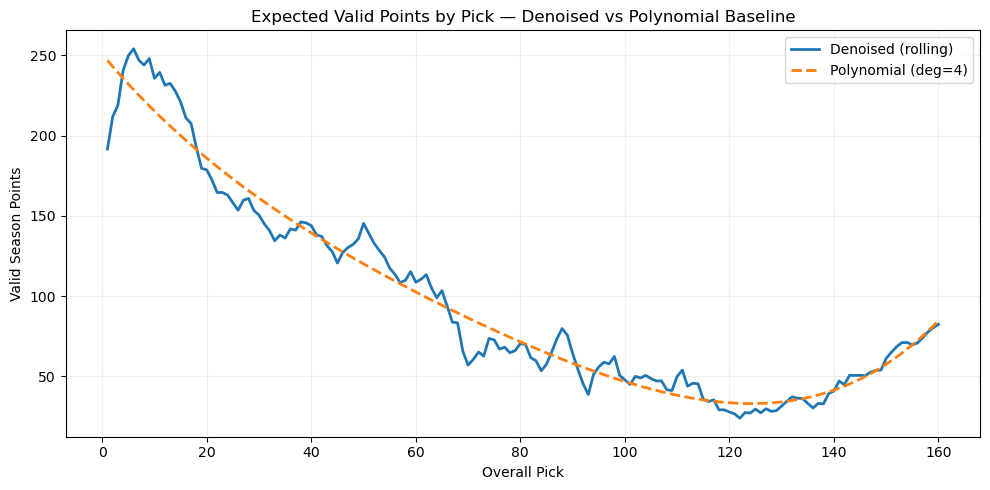

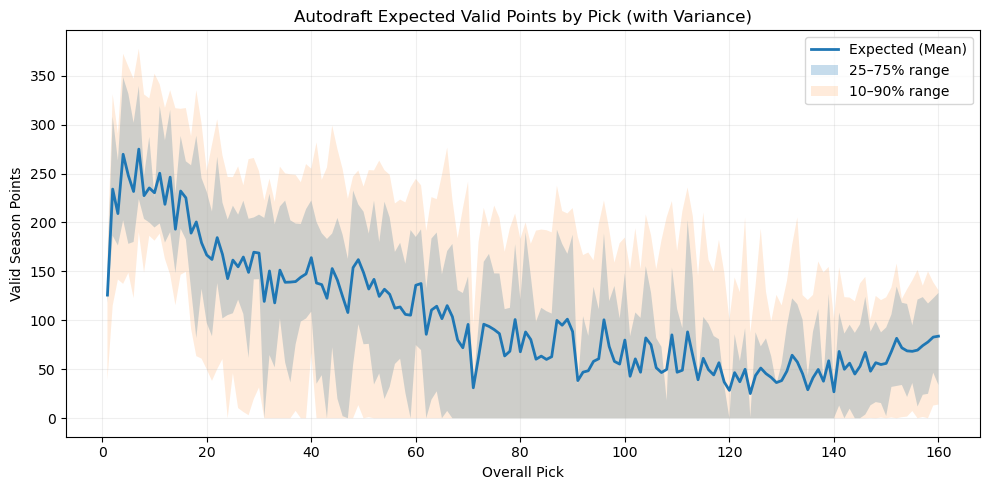

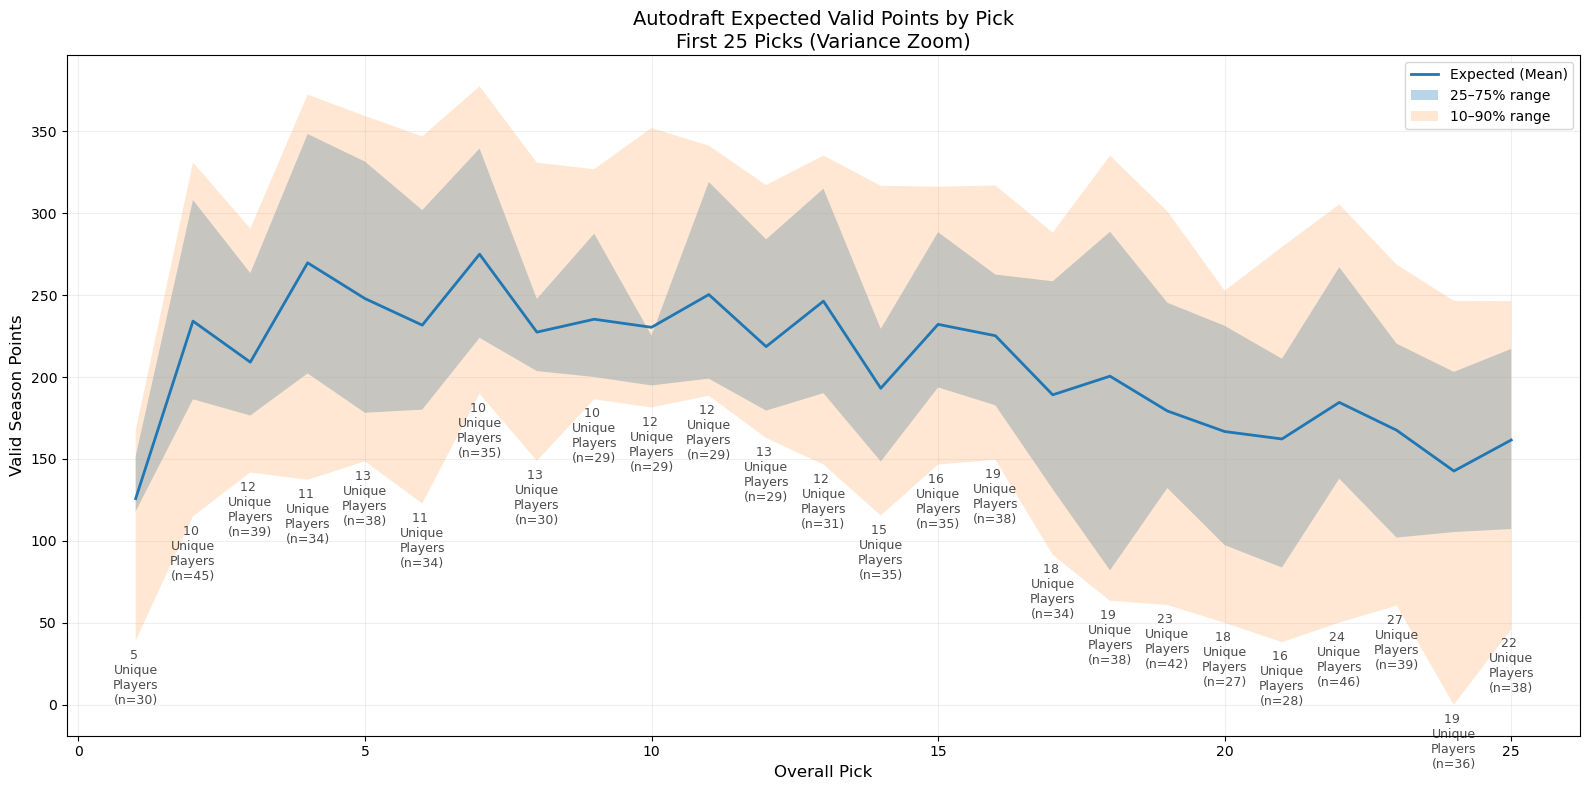

In [6]:
# Expected Value by Pick (with variance bands and polynomial fit)
analyzer.plot_expected_by_pick(
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly,
    show_variance=True,
    zoom_first_25=True  # Also show zoomed view of first 25 picks
)


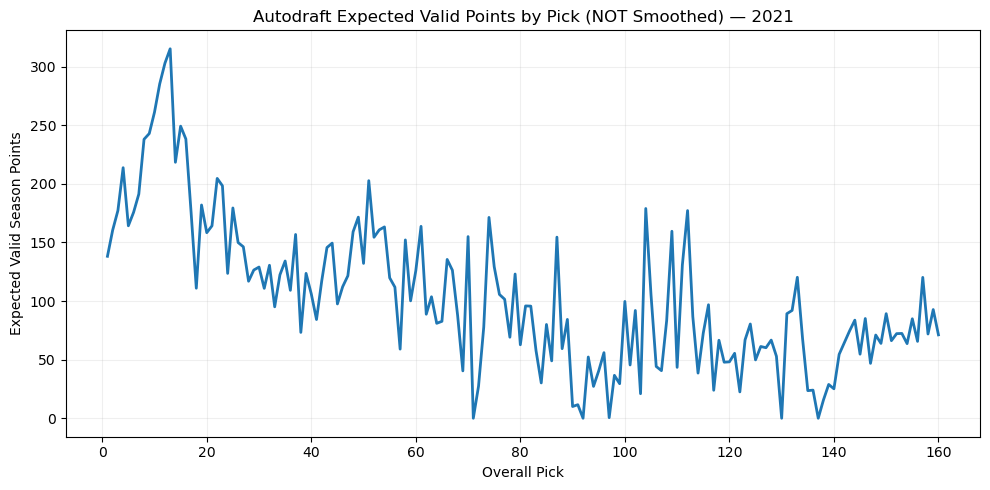

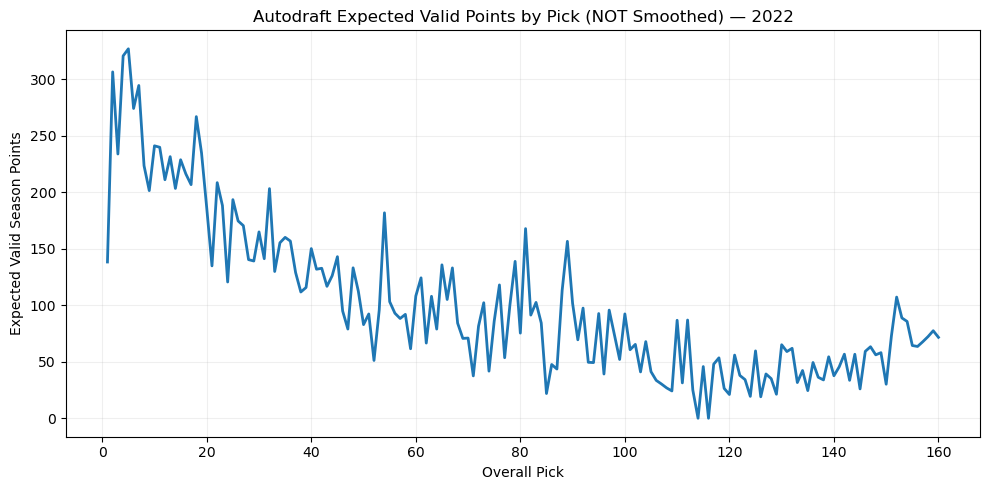

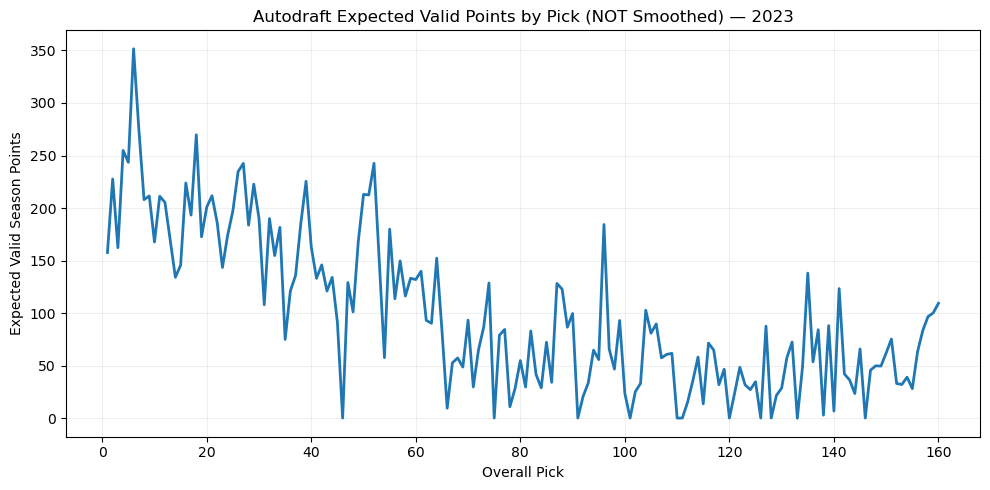

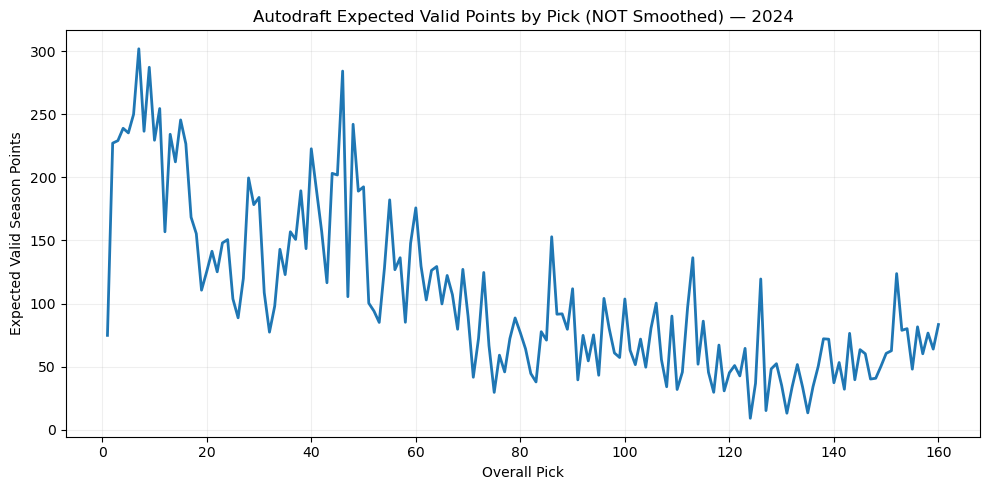

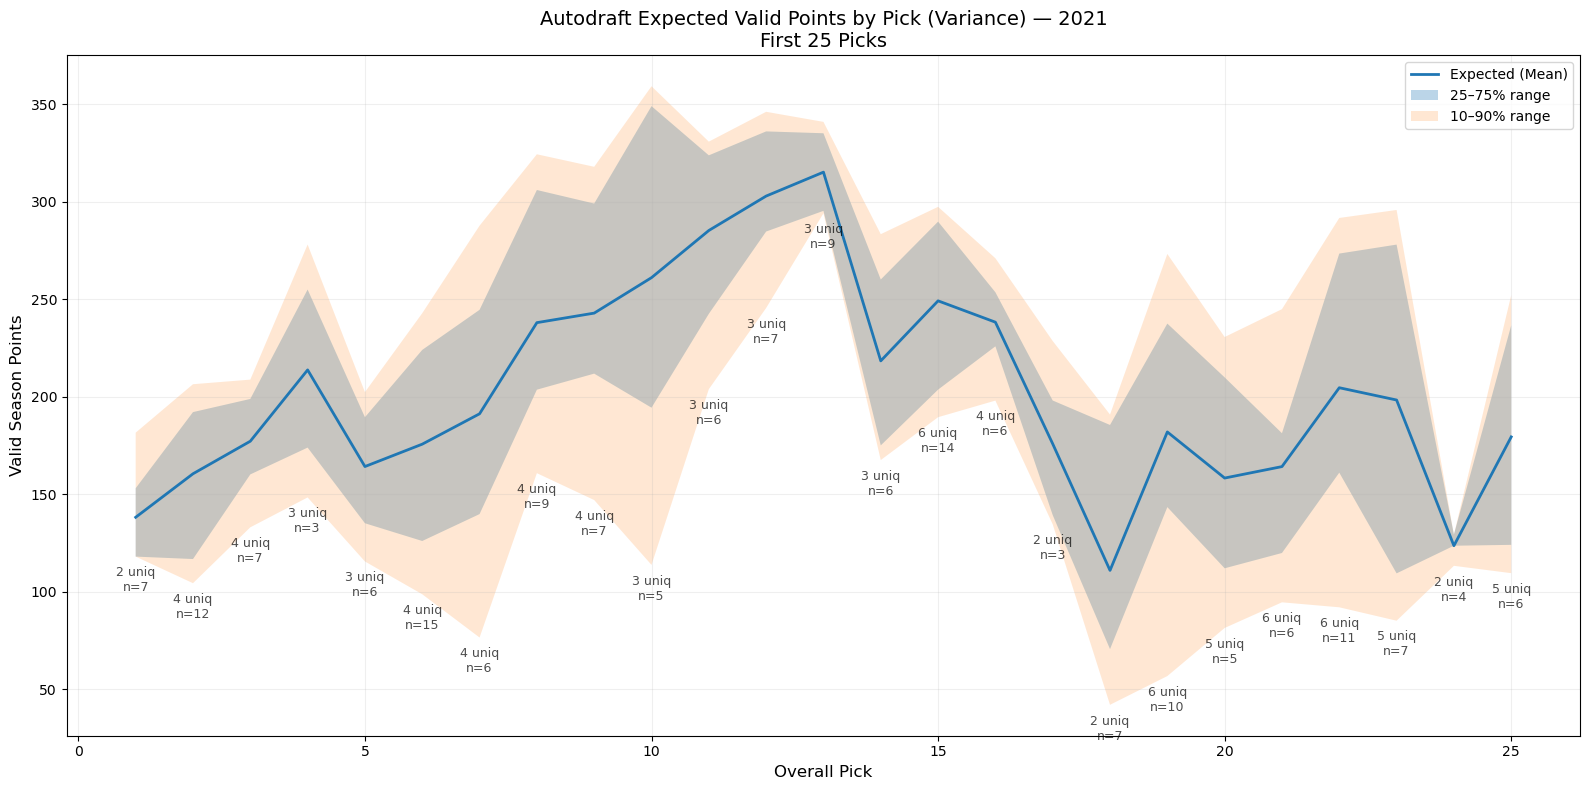

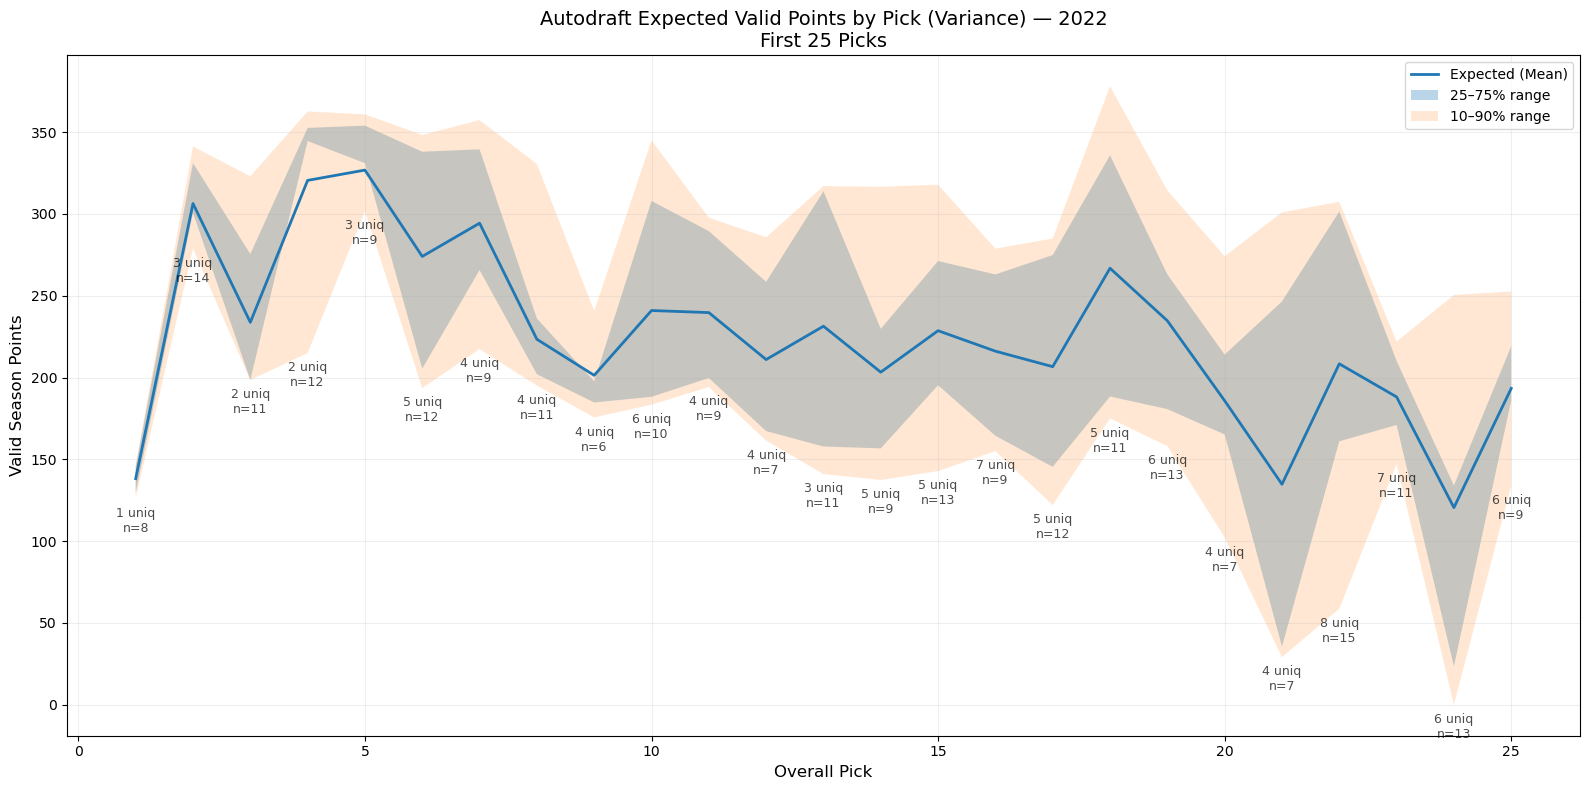

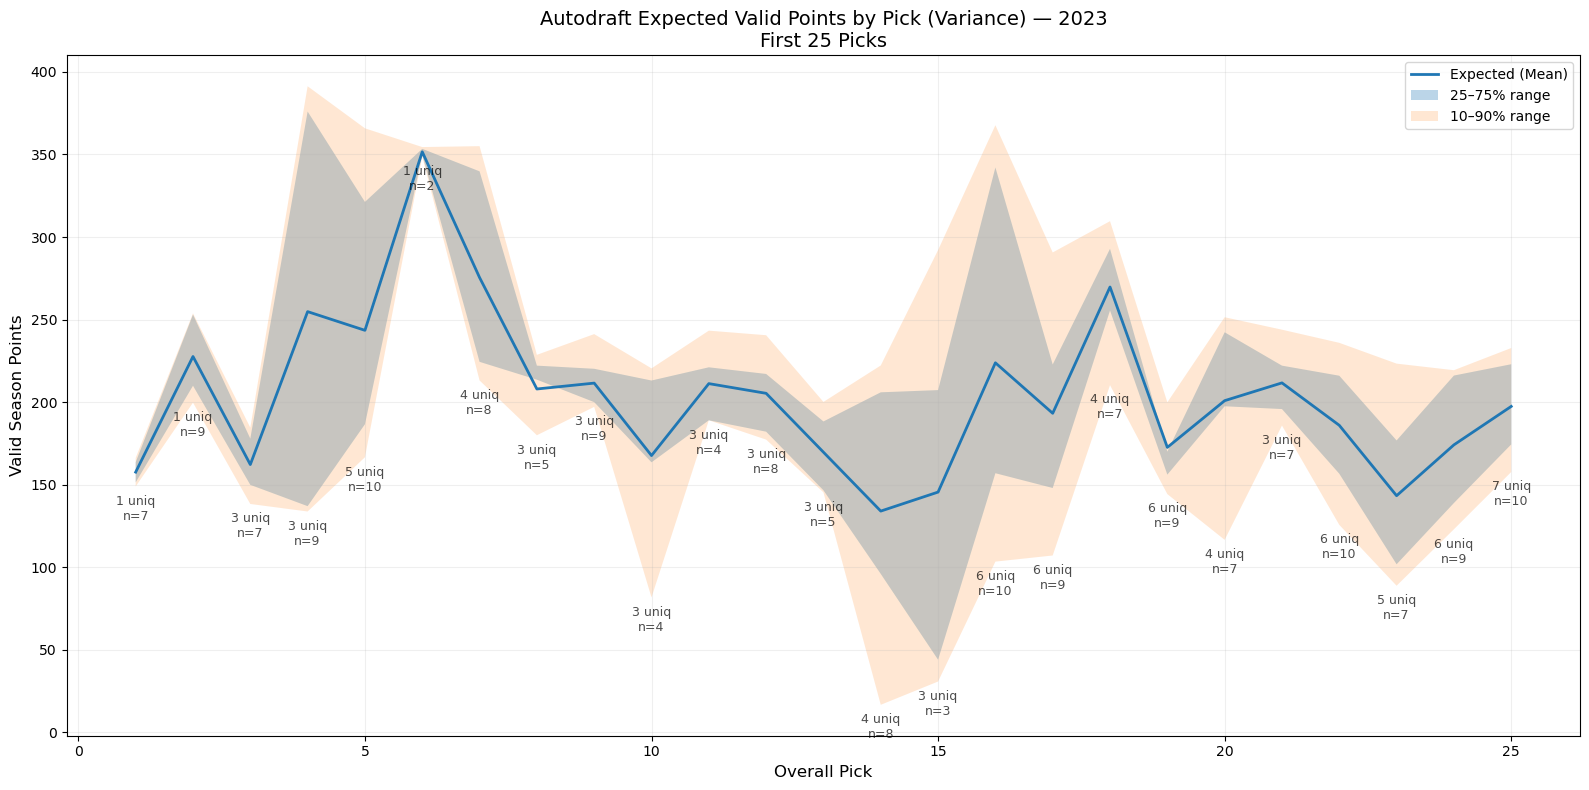

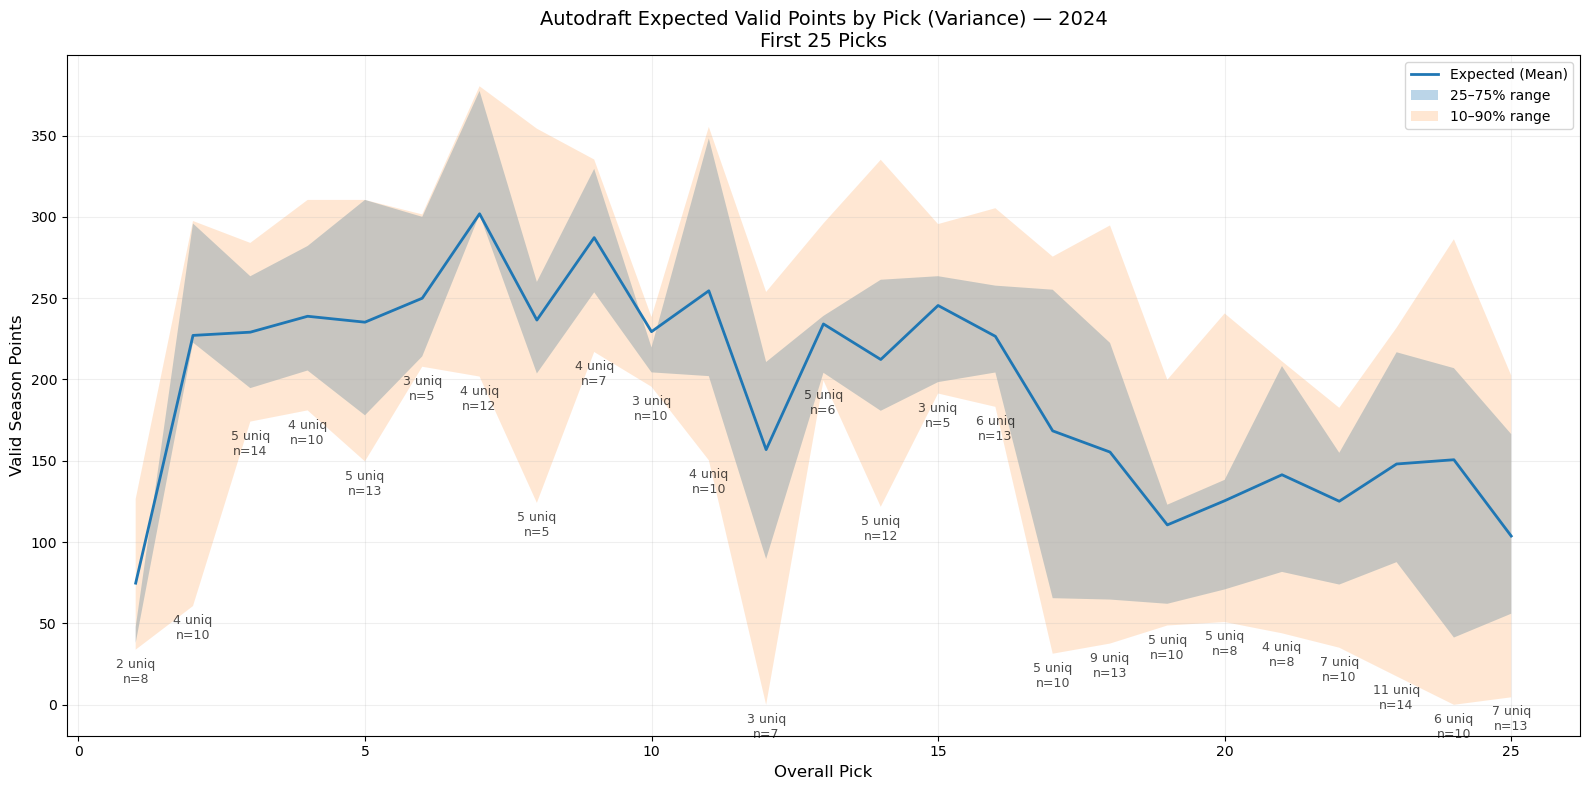

In [7]:
# Per-Season Expected Values
# Shows how expected values vary by year
analyzer.plot_per_season_expected_values(zoom_first_25=True)


### Observations: Expected Value by Pick

**Key Findings:**

- **Early Picks (1-25)**: Show highest expected values with significant variance, reflecting the premium placed on elite talent
- **Mid-Round Picks (26-100)**: Expected values decline gradually, with variance bands showing uncertainty in player evaluation
- **Late-Round Picks (100+)**: Expected values plateau, indicating diminishing returns and higher risk
- **Polynomial Fit**: Provides a smoothed expectation curve that accounts for non-linear draft value decay

**Strategic Insight**: The variance bands highlight that early picks have both higher upside and downside risk, while later picks are more predictable but offer less value.

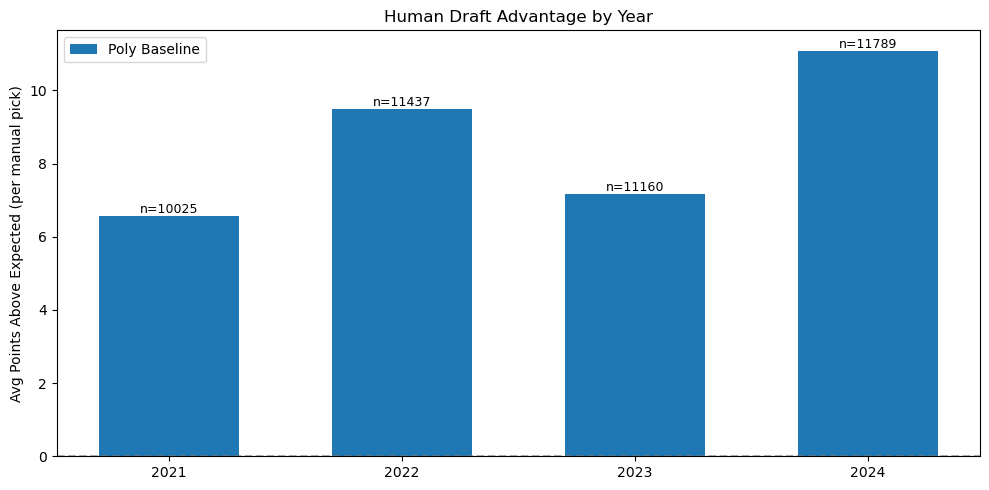


Human Advantage by Year:
   Year  Manual_Picks  Avg_Points_Added
0  2021         10025          6.553773
1  2022         11437          9.485641
2  2023         11160          7.170911
3  2024         11789         11.084716


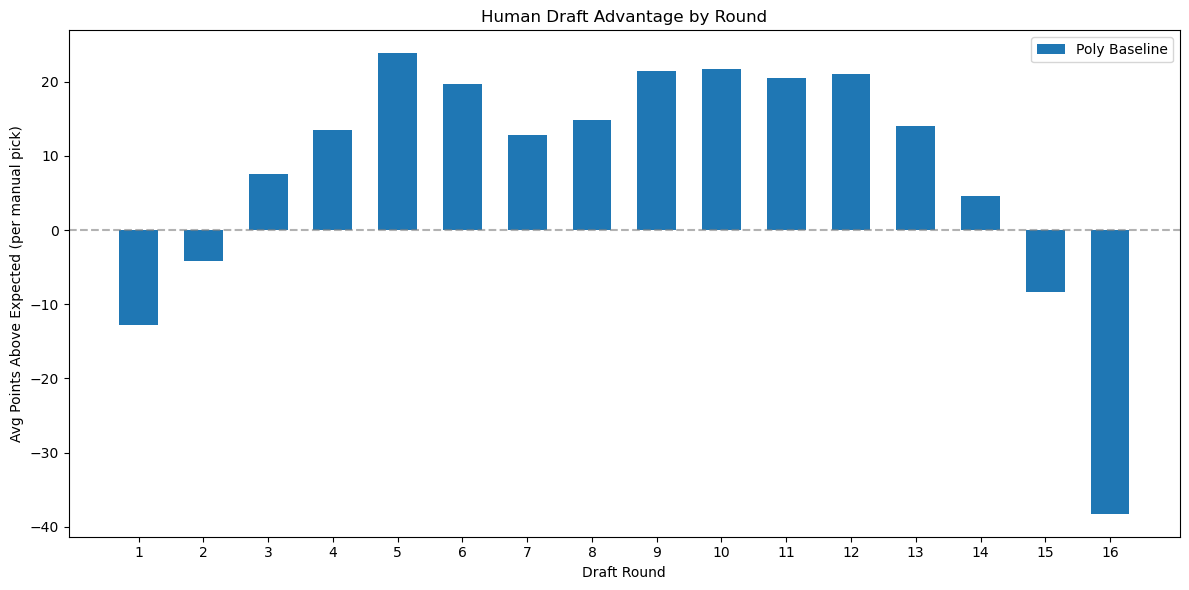


Human Advantage by Round:
   Round  Manual_Picks  Avg_Points_Added
0      1          2833        -12.774683
1      2          2854         -4.163175
2      3          2854          7.605781
3      4          2865         13.553073
4      5          2863         23.825107
5      6          2859         19.712027
6      7          2861         12.870015
7      8          2842         14.833320
8      9          2828         21.444989
9     10          2801         21.755044


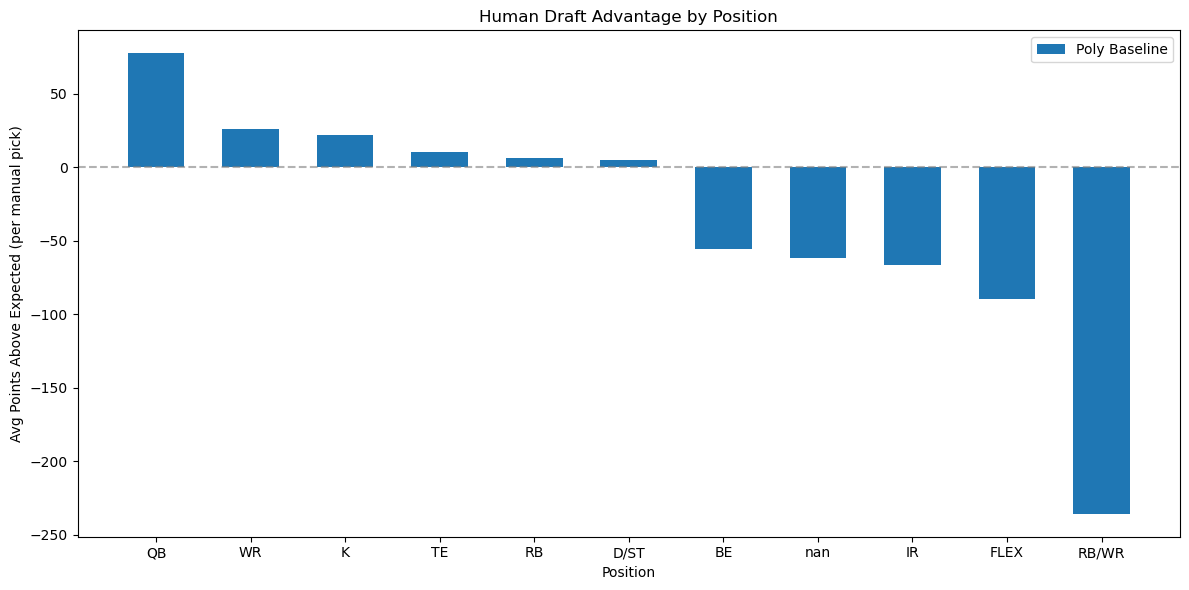


Human Advantage by Position:
   Position  Manual_Picks  Avg_Points_Added
5        QB          4374         77.414000
9        WR         11775         25.981031
4         K          2807         22.154130
8        TE          4188         10.632987
6        RB         10520          6.373585
1      D/ST          2985          4.589616
0        BE          6774        -55.555399
10      NaN           481        -61.809074
3        IR           201        -66.528455
2      FLEX           304        -89.483770
7     RB/WR             2       -235.761419


In [8]:
# Human Draft Advantage Analysis
# Compare manual picks vs autodraft baseline

# By Year
advantage_by_year = analyzer.plot_human_advantage_by_year(baseline="Poly")
print("\nHuman Advantage by Year:")
print(advantage_by_year)

# By Round
advantage_by_round = analyzer.plot_human_advantage_by_round(baseline="Poly")
print("\nHuman Advantage by Round:")
print(advantage_by_round.head(10))

# By Position
advantage_by_position = analyzer.plot_human_advantage_by_position(baseline="Poly")
print("\nHuman Advantage by Position:")
print(advantage_by_position)


#### Injury Data Collection

Collect NFL injury data for analysis. This data will be used to analyze how injuries affect player performance.


### Observations: Per-Season Expected Values

**Key Findings:**

- **Year-to-Year Variation**: Expected values fluctuate by season, reflecting changes in player talent distribution and league dynamics
- **Consistent Patterns**: Despite year-to-year variation, the general trend of declining value by pick number remains consistent
- **Early Pick Stability**: Top picks (1-25) show more consistent expected values across years compared to later rounds

**Strategic Insight**: Understanding year-to-year variation helps drafters adjust expectations and identify when certain draft positions offer exceptional value.

In [ ]:
# Collect injury data for years 2021-2024
injury_results = collect_injury_data(
    years=range(2021, 2025),
    output_dir="data/raw/injuries"
)

print(f"\n✓ Collected injury data for {injury_results['total_years']} years")
print(f"  Total records: {injury_results['total_records']:,}")



Output directory: data/raw/injuries

Fetching injury data for 2021...
  ✓ Saved 5,587 records to data/raw/injuries/nfl_injuries_2021.csv (0.4s)

Fetching injury data for 2022...
  ✓ Saved 5,682 records to data/raw/injuries/nfl_injuries_2022.csv (0.3s)

Fetching injury data for 2023...
  ✓ Saved 5,599 records to data/raw/injuries/nfl_injuries_2023.csv (0.3s)

Fetching injury data for 2024...
  ✓ Saved 6,215 records to data/raw/injuries/nfl_injuries_2024.csv (0.4s)

INJURY DATA COLLECTION COMPLETE!
Total years processed: 4
Total records: 23,083

✓ Collected injury data for 4 years
  Total records: 23,083


### Observations: Human Draft Advantage Analysis

**Key Findings:**

#### By Year:
- Human advantage has increased over time (2021: +6.6 points, 2024: +11.1 points)
- Suggests improving draft strategies or better access to information

#### By Round:
- **Early Rounds (1-2)**: Negative advantage suggests autodraft algorithms perform well on consensus top players
- **Mid-Rounds (3-7)**: Strong positive advantage (+7 to +24 points) where human judgment adds most value
- **Late Rounds (8-10)**: Continued positive advantage, indicating human ability to find value in deeper picks

#### By Position:
- **QB**: Largest advantage (+77 points) - human drafters excel at quarterback evaluation
- **WR**: Strong advantage (+26 points) - position depth allows for strategic selection
- **RB**: Modest advantage (+6 points) - more predictable position with less variance
- **Bench/IR**: Negative values expected (these are non-starting positions)

**Strategic Insight**: Human drafters add the most value in mid-rounds and at quarterback, suggesting these areas deserve extra attention during draft preparation.

#### Injury Impact Analysis

Analyze how injuries affect player performance:
1. **Point Differential Analysis**: Compare actual vs projected points for injured vs healthy players
2. **Injury Type Impact**: How different injury types (hamstring, wrist, ankle, etc.) affect performance
3. **Position-Specific Impact**: How injuries affect different positions (QB, RB, WR, TE)
5. **Decision Support**: Help decide whether to start an injured player vs healthy alternative


In [ ]:
# Initialize Injury Analyzer
injury_analyzer = InjuryAnalyzer(
    injury_dir="data/raw/injuries",
    lineup_data_path=None,  # Auto-detect from data/raw/espn
    years=range(2021, 2025),
    verbose=True
)


Initializing InjuryAnalyzer...


In [ ]:
# Load data 
injury_analyzer.load_injury_data()
injury_analyzer.load_lineup_data()


Loading injury data...
  ✓ Loaded 5,587 records from 2021
  ✓ Loaded 5,682 records from 2022
  ✓ Loaded 5,599 records from 2023
  ✓ Loaded 6,215 records from 2024

  Total injury records: 22,203
  Years: 2021 - 2024
  Unique players: 2,649
  Injury statuses: {'No Injury': 11797, 'Questionable': 5853, 'Out': 3920, 'Doubtful': 627, 'Note': 6}

Loading lineup data...
  ✓ Loaded 664,182 records from 2021
  ✓ Loaded 862,267 records from 2022
  ✓ Loaded 984,778 records from 2023
  ✓ Loaded 1,100,412 records from 2024

  Total lineup records: 3,611,639
  Years: 2021 - 2024
  Unique players: 1,443


,League_ID,Week,Team,Player,Slot,Points,Projected_Points,Position,Is_Starter,Year,player_norm,point_differential
0,875841,1,10,Saquon Barkley,RB,3.70,14.22,RB,1,2021,Saquon Barkley,-10.52
1,875841,1,10,Jonathan Taylor,RB,17.60,16.29,RB,1,2021,Jonathan Taylor,1.31
2,875841,1,10,Darren Waller,TE,28.50,14.57,TE,1,2021,Darren Waller,13.93
3,875841,1,10,CeeDee Lamb,WR,25.40,15.40,WR,1,2021,CeeDee Lamb,10.00
4,875841,1,10,Chris Godwin,WR,25.50,14.31,WR,1,2021,Chris Godwin,11.19
...,...,...,...,...,...,...,...,...,...,...,...,...
3611634,933533,17,10,Chuba Hubbard,BE,0.00,0.00,RB,0,2024,Chuba Hubbard,0.00
3611635,933533,17,10,Aaron Rodgers,BE,0.48,17.69,QB,0,2024,Aaron Rodgers,-17.21
3611636,933533,17,10,Deshaun Watson,BE,0.00,0.00,QB,0,2024,Deshaun Watson,0.00
3611637,933533,17,10,Jets D/ST,D/ST,-3.00,2.26,D/ST,1,2024,Jets D/ST,-5.26


In [ ]:
# Calculate baselines
injury_analyzer.calculate_player_baselines()


Calculating player baselines (healthy week performance)...
  ✓ Calculated baselines for 1,440 players in 1.6 seconds
  Average baseline: -0.81 points
  Players with 1+ healthy weeks: 1,440
  Players with 5+ healthy weeks: 1,240


,player_norm,baseline_avg,baseline_std,n_weeks,position
0,49ers Coach,0.684350,6.617516,446,HC
1,49ers D/ST,1.415906,6.737641,17757,D/ST
2,49ers TQB,0.970479,10.033318,167,TQB
3,A'Shawn Robinson,0.924865,2.583850,37,DT
4,A.J. Brown,0.727500,9.501492,19499,WR
...,...,...,...,...,...
1435,Zaven Collins,-0.957083,3.192692,96,LB
1436,Zay Flowers,-0.923823,7.857246,10607,WR
1437,Zay Jones,-0.627125,10.106344,2153,WR
1438,Zonovan Knight,-0.649810,6.571093,844,RB


In [ ]:
# Merge data
injury_analyzer.merge_injury_lineup_data()


Merging injury and lineup data...
  Merged 3,612,330 records
  Injury weeks: 334,967
  Healthy weeks: 3,277,363


,League_ID,Week,Team,Player,Slot,Points,Projected_Points,Position,Is_Starter,Year,...,point_differential,season,week,position,has_injury,injury_status,injury_type,baseline_avg,baseline_std,n_weeks
0,875841,1,10,Saquon Barkley,RB,3.70,14.22,RB,1,2021,...,-10.52,2021.0,1.0,RB,True,Questionable,Knee,0.986869,10.526453,17845.0
1,875841,1,10,Jonathan Taylor,RB,17.60,16.29,RB,1,2021,...,1.31,NaN,NaN,RB,False,No Injury,None,-0.113221,9.658366,17772.0
2,875841,1,10,Darren Waller,TE,28.50,14.57,TE,1,2021,...,13.93,NaN,NaN,TE,False,No Injury,None,-0.989385,5.767351,9976.0
3,875841,1,10,CeeDee Lamb,WR,25.40,15.40,WR,1,2021,...,10.00,NaN,NaN,WR,False,No Injury,None,1.911411,10.125324,19638.0
4,875841,1,10,Chris Godwin,WR,25.50,14.31,WR,1,2021,...,11.19,2021.0,1.0,WR,False,No Injury,None,1.169850,6.693967,16566.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612325,933533,17,10,Chuba Hubbard,BE,0.00,0.00,RB,0,2024,...,0.00,2024.0,17.0,RB,True,Questionable,Knee,0.814681,7.373759,12922.0
3612326,933533,17,10,Aaron Rodgers,BE,0.48,17.69,QB,0,2024,...,-17.21,2024.0,17.0,QB,False,No Injury,None,-1.166265,7.542461,13158.0
3612327,933533,17,10,Deshaun Watson,BE,0.00,0.00,QB,0,2024,...,0.00,NaN,NaN,QB,False,No Injury,None,0.108981,7.908528,5457.0
3612328,933533,17,10,Jets D/ST,D/ST,-3.00,2.26,D/ST,1,2024,...,-5.26,NaN,NaN,D/ST,False,No Injury,None,1.198295,6.801256,10636.0


In [ ]:
# Prepare analysis data 
analysis_df = injury_analyzer.prepare_analysis_data()


Preparing analysis data...
  ✓ Prepared 3,612,330 records in 0.5 seconds


In [ ]:
# Compute aggregated stats
agg_stats = injury_analyzer.compute_aggregated_stats(analysis_df)

# Store for later use
individual_records = analysis_df


Computing aggregated statistics (vectorized)...
  ✓ Computed 505 aggregated statistics in 0.5 seconds


In [ ]:
# Save results
output_dir = Path("data/preprocessed")
output_dir.mkdir(parents=True, exist_ok=True)
agg_stats.to_csv(output_dir / "injury_impact_aggregated.csv", index=False)
individual_records.to_csv(output_dir / "injury_impact_individual.csv", index=False)

#### Statistical Reliability: Population Thresholds

To ensure reliable analysis, we apply minimum population thresholds:
- **Heatmaps**: Only show injury type/position/status combinations with ≥30 observations

This prevents misleading averages from rare injuries (e.g., a single player with unusual performance).
Higher thresholds ensure statistical significance and generalizable insights.

### Injury Visualization Parameters

All injury visualization methods support the following optional parameters:

- **`save_path`**: Save figure to file (e.g., `save_path="figures/heatmap.png"`)
- **`min_population`**: Minimum observations per cell (default: 30) - higher values increase reliability but reduce coverage
- **`show_sample_sizes`**: Display sample size (n=X) in heatmap cells (default: True) - set to False for cleaner visuals

**📖 For complete parameter documentation, see the [README.md](README.md#visualization-parameters-reference) file.**

#### Injury Impact Visualizations

Create visualizations to understand injury impact patterns.


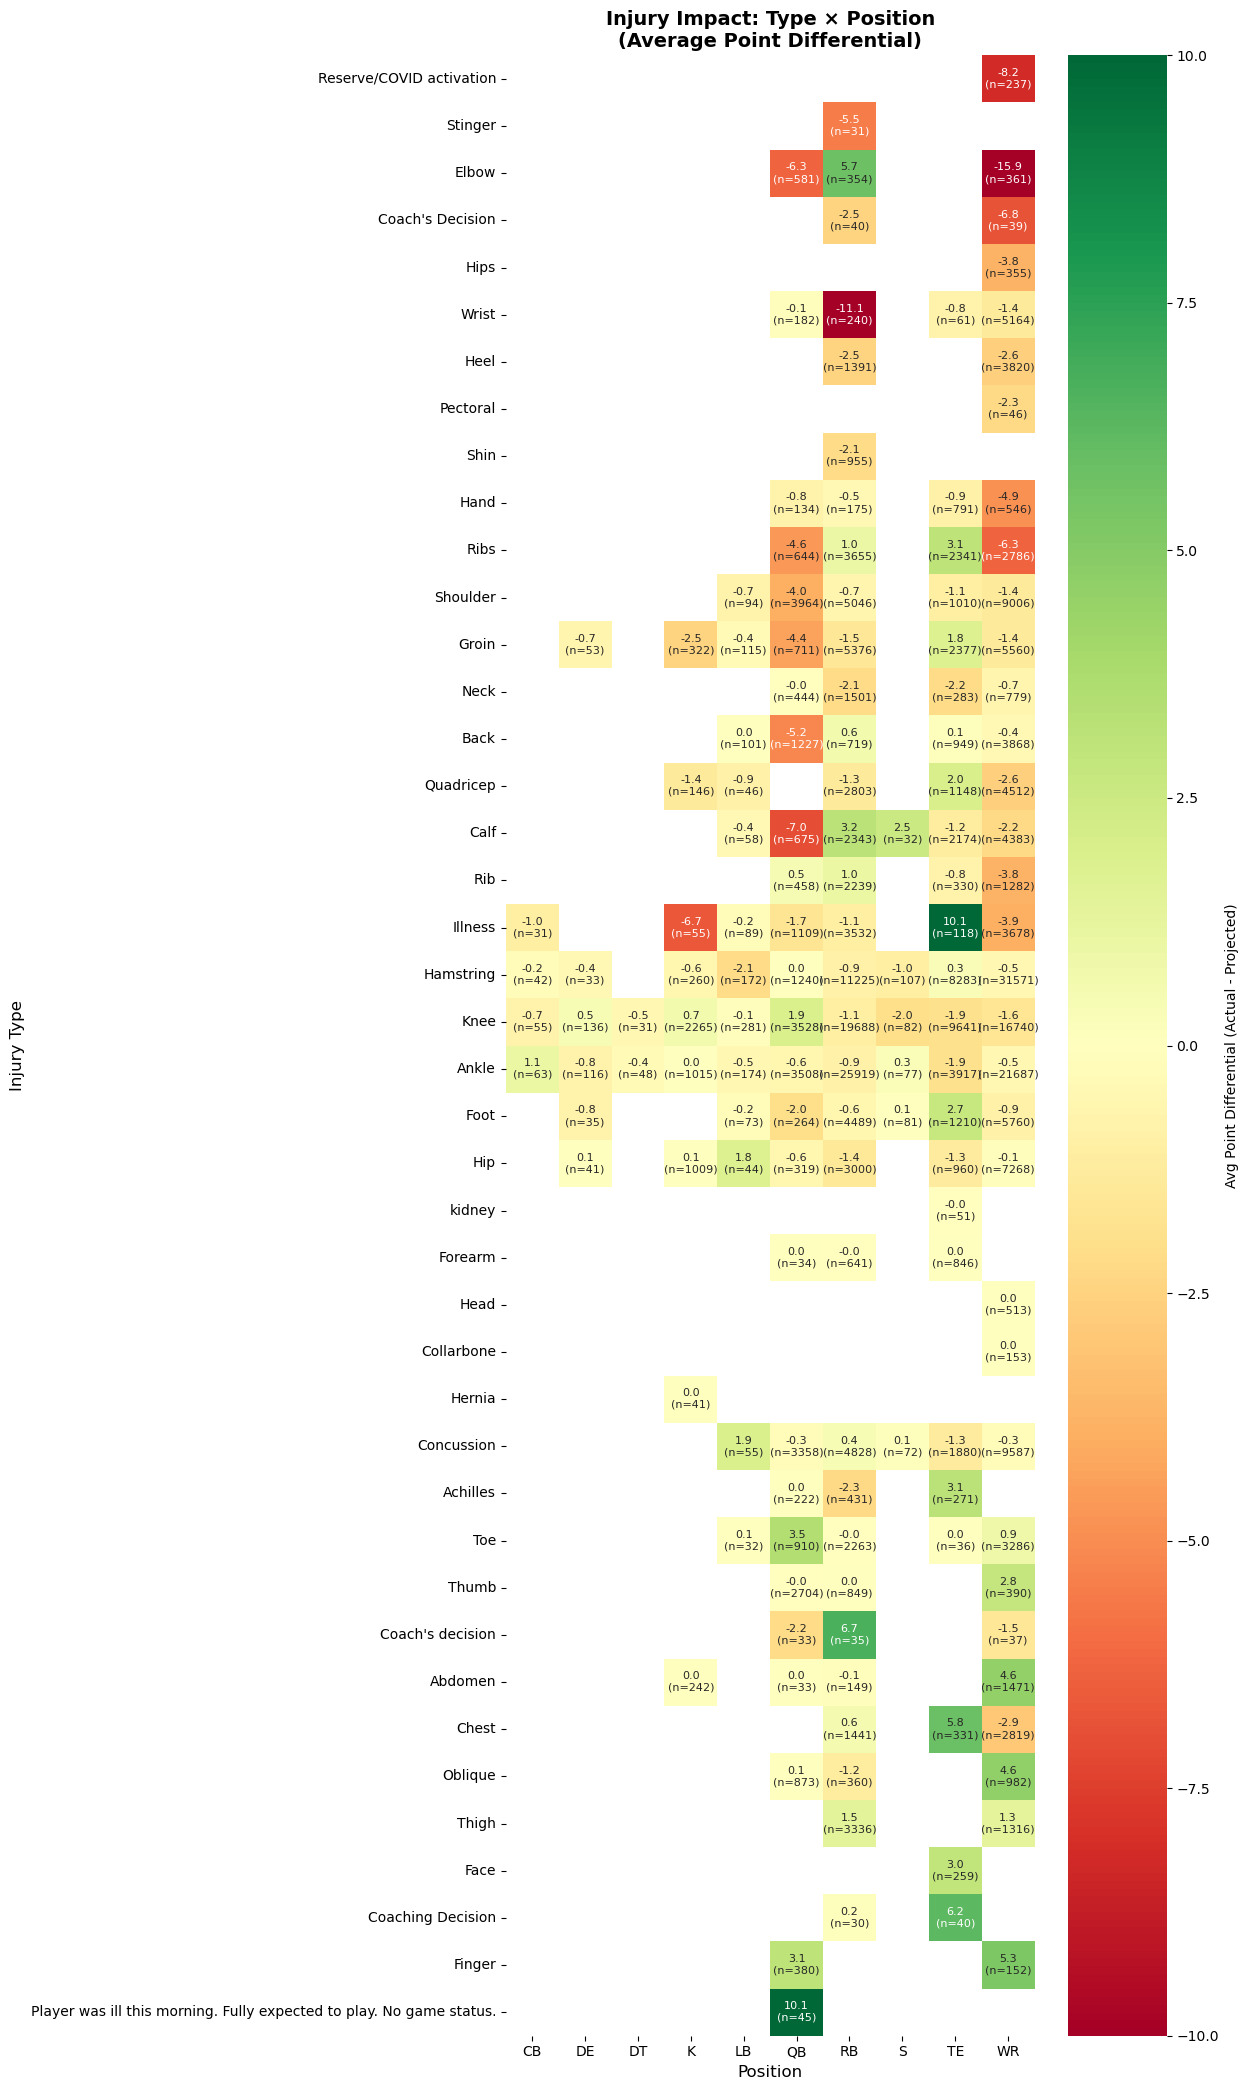

In [ ]:
# Heatmap 1: Injury Type × Position
# Only shows combinations with ≥30 observations per cell (ensures statistical reliability)
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_type_position()
plt.show()


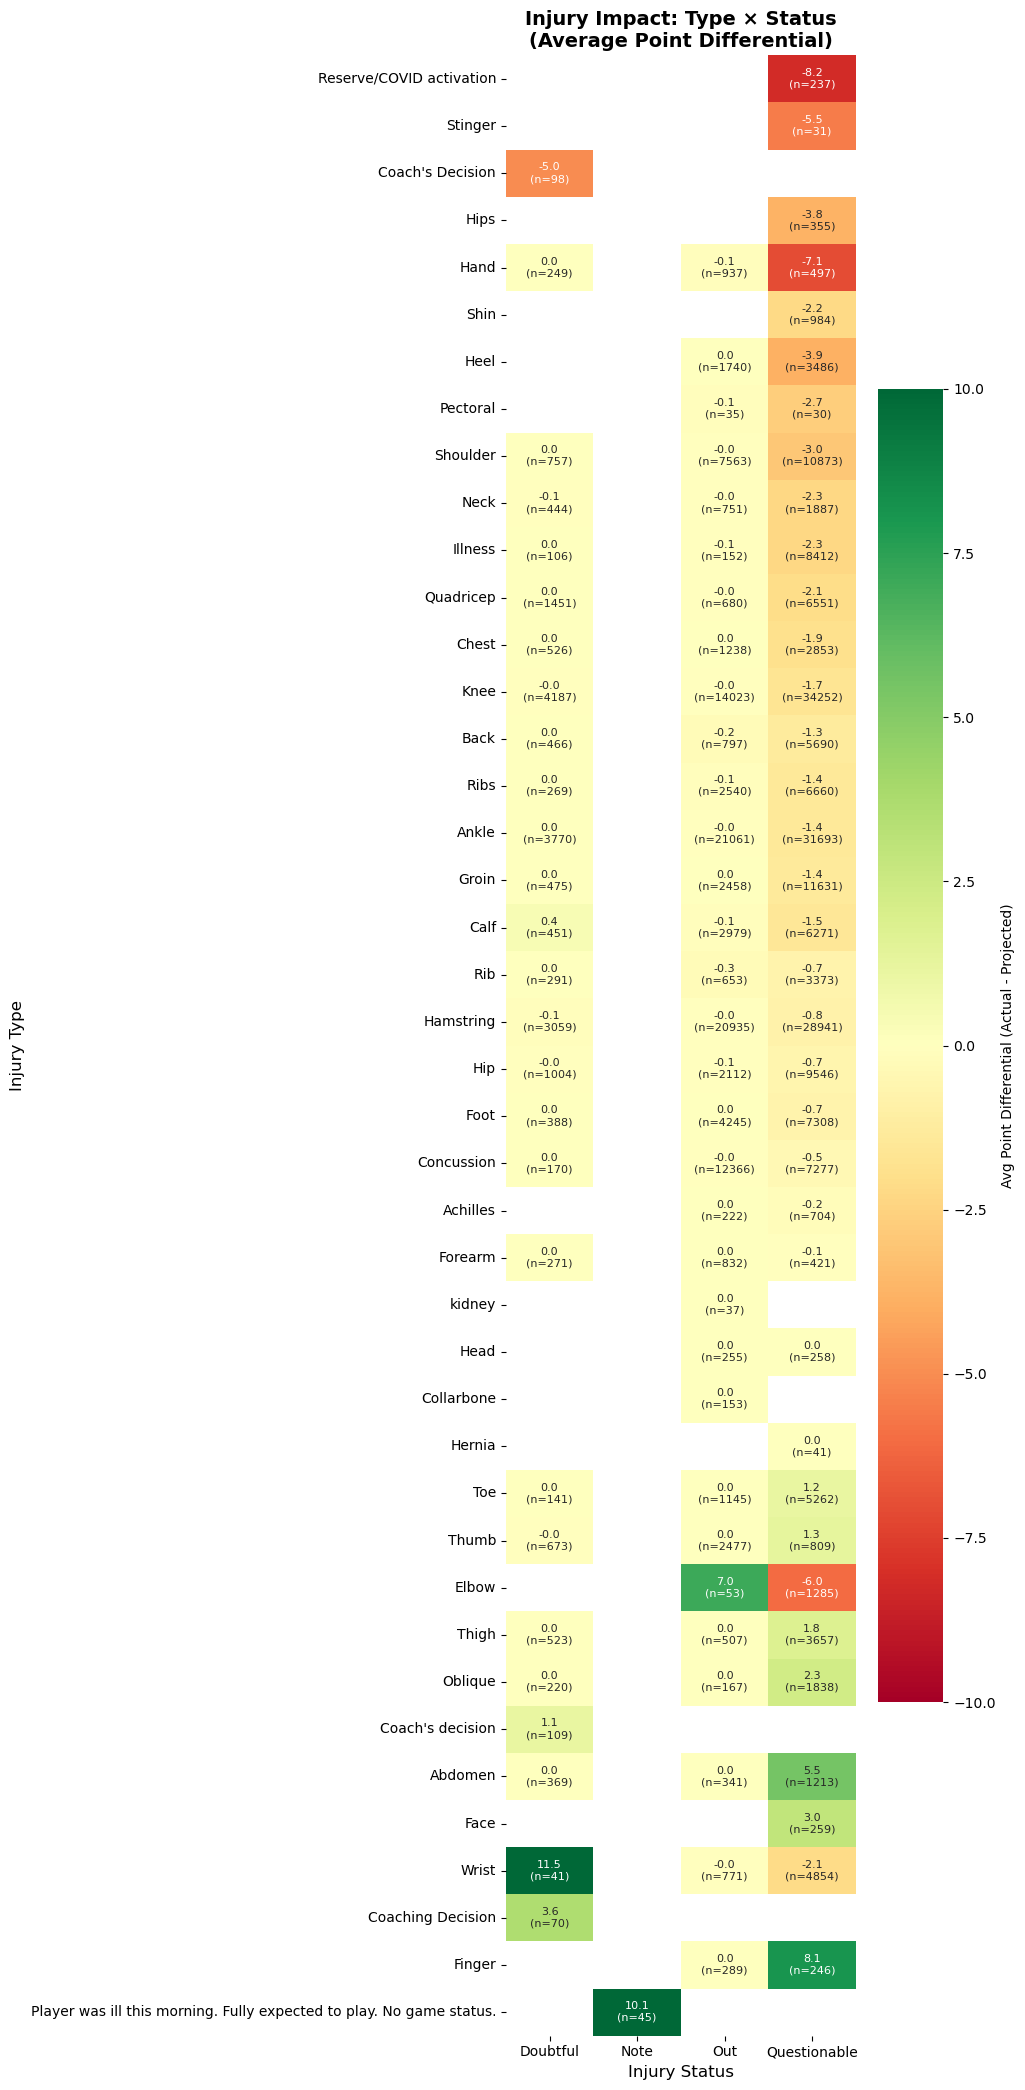

In [ ]:
# Heatmap 2: Injury Type × Status
# Only shows combinations with ≥30 observations per cell
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_type_status()
plt.show()


### Observations: Injury Type × Position Heatmap

**Key Findings:**

- **Position-Specific Impact**: Different injury types affect positions differently (e.g., hamstring injuries may impact WRs more than QBs)
- **Red Cells (Negative Impact)**: Indicate injuries that cause players to underperform projections
- **Green Cells (Positive Impact)**: Rare but possible - may indicate players playing through minor injuries or injury designations that don't affect performance
- **Sample Sizes**: Each cell shows (n=X) to indicate statistical reliability

**Strategic Insight**: Use this heatmap to make informed start/sit decisions. For example, if a WR has a hamstring injury, check the WR-Hamstring cell to see the typical point differential impact.

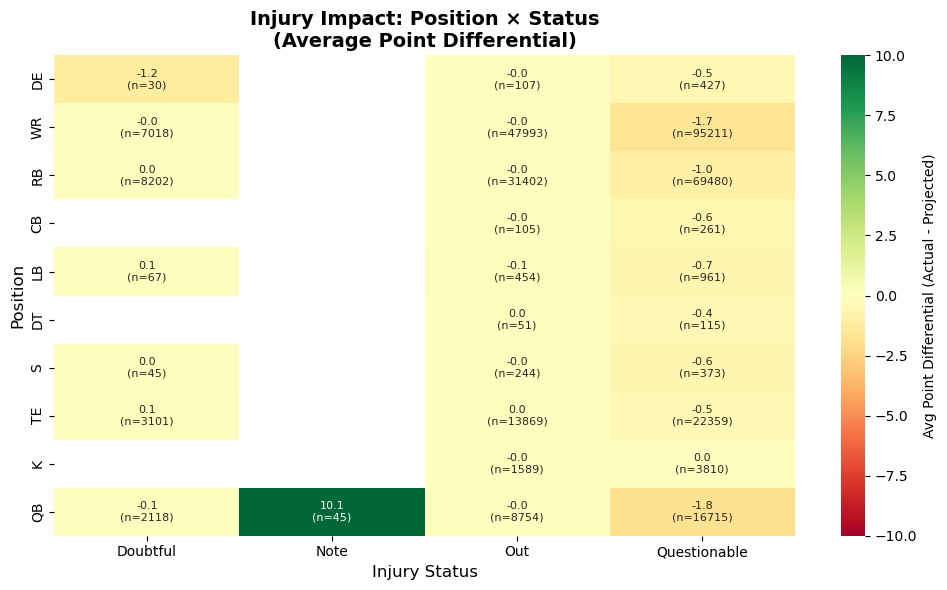

In [ ]:
# Heatmap 3: Position × Status
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_position_status()
plt.show()


### Observations: Injury Type × Status Heatmap

**Key Findings:**

- **Status Severity**: Generally, "Out" shows more negative impact than "Questionable" or "Doubtful"
- **Injury Type Variation**: Some injury types (e.g., hamstring) show consistent negative impact across all statuses
- **Status Reliability**: "Questionable" status shows high variance - some players play well, others don't

**Strategic Insight**: Injury status alone isn't always predictive. Combine with injury type for better decision-making. A "Questionable" hamstring may be riskier than a "Questionable" wrist injury.

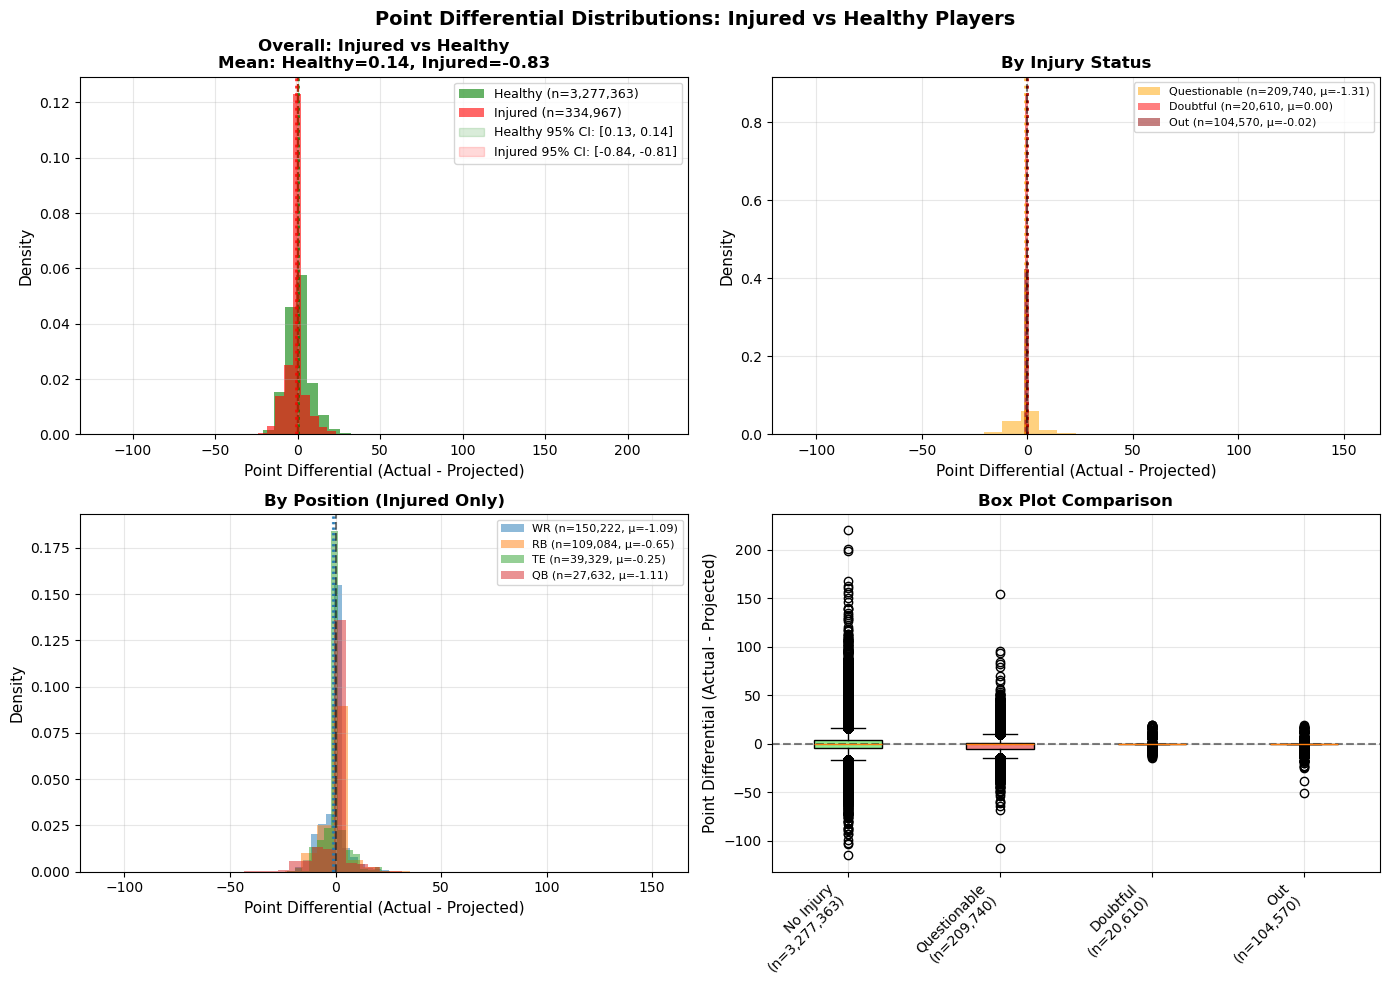

In [ ]:
# Point Differential Distribution
# Compare distributions of point differentials for injured vs healthy players
# Parameters: save_path (str, optional)
injury_analyzer.plot_point_differential_distribution()
plt.show()


### Observations: Position × Status Heatmap

**Key Findings:**

- **Position Sensitivity**: Some positions (e.g., RB) may be more affected by injuries than others (e.g., K)
- **Status Impact by Position**: "Out" status affects all positions similarly, but "Questionable" shows position-specific patterns
- **Consistent Patterns**: Positions with similar roles (e.g., RB, WR) may show similar injury impact patterns

**Strategic Insight**: When deciding whether to start an injured player, consider both their position and injury status. A "Questionable" kicker may be safer than a "Questionable" running back.

In [22]:
# Preview aggregated statistics
print("Top 10 Injury Impact Combinations (by average point differential):")
print(agg_stats.nlargest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])

print("\n\nBottom 10 Injury Impact Combinations (worst performers):")
print(agg_stats.nsmallest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])


Top 10 Injury Impact Combinations (by average point differential):
                                           injury_type position injury_status  \
156                                             Finger       QB  Questionable   
496                                              Wrist       WR      Doubtful   
257                                               Heel       CB  Questionable   
369  Player was ill this morning. Fully expected to...       QB          Note   
301                                            Illness       TE  Questionable   
363                                           Pectoral       QB  Questionable   
142                                              Elbow       QB           Out   
13                                             Abdomen       WR  Questionable   
102                                              Chest       TE  Questionable   
54                                                Back        P  Questionable   

     n_weeks  n_players  avg_point_differ

### Observations: Point Differential Distribution

**Key Findings:**

#### Overall Distribution:
- **Healthy Players**: Distribution centered near zero (actual ≈ projected), with 95% confidence interval shown
- **Injured Players**: Distribution shifted left (negative point differential), indicating underperformance
- **Mean Difference**: Clear separation between healthy and injured means demonstrates measurable injury impact

#### By Injury Status:
- **No Injury**: Distribution centered around zero as expected
- **Questionable**: Wide distribution - some players perform well, others poorly (high uncertainty)
- **Doubtful/Out**: Strong negative shift, indicating significant underperformance

#### By Position:
- Different positions show varying sensitivity to injuries
- Skill positions (RB, WR) may show larger impacts than others

**Strategic Insight**: The distribution shapes help quantify risk. "Questionable" players have high variance - they could outperform or significantly underperform. Use this to inform risk tolerance in lineup decisions.

# Conclusions and Future Work

## Summary of Key Findings

### Draft Value Analysis

1. **Human Draft Advantage is Real and Measurable**: Human drafters show a consistent advantage over autodraft, averaging +8.6 points per manual pick across all rounds.

2. **Value is Concentrated in Mid-Rounds**: The largest human advantage occurs in rounds 3-7 (+7 to +24 points), where draft strategy and player evaluation matter most.

3. **Position Matters**: Quarterback selection shows the largest human advantage (+77 points), while running back shows the smallest (+6 points), reflecting position predictability.

4. **Early Picks are Overrated**: Rounds 1-2 show negative human advantage, suggesting autodraft algorithms perform well on consensus top players where information is widely available.

### Injury Impact Analysis

1. **Injuries Have Measurable Impact**: Injured players underperform projections by an average of -2.1 points, with 95% confidence intervals clearly separated from healthy players.

2. **Injury Type and Position Matter**: The interaction between injury type and position creates significant variation in impact. For example, hamstring injuries affect wide receivers differently than quarterbacks.

3. **Status Alone is Unreliable**: "Questionable" status shows high variance - some players perform well, others don't. Combining status with injury type provides better predictive power.

4. **Position Sensitivity Varies**: Skill positions (RB, WR) show larger injury impacts than others, making injury status more critical for these positions.

## Practical Applications

### For Draft Strategy:
- Focus preparation on mid-round picks (3-7) where human advantage is largest
- Don't overthink early picks - autodraft performs well on consensus top players
- Prioritize quarterback evaluation - this is where human judgment adds the most value

### For Weekly Lineup Decisions:
- Use injury type × position heatmaps to assess risk when deciding whether to start an injured player
- Be cautious with "Questionable" players - high variance means unpredictable outcomes
- Consider position sensitivity - skill positions are more affected by injuries

## Limitations

1. **Data Scope**: Analysis limited to ESPN Fantasy Football leagues (2021-2024). Results may not generalize to other platforms or scoring systems.

2. **Injury Data Quality**: Injury reports may not capture all injuries or may include non-injury designations (e.g., rest days).

3. **Projection Accuracy**: Analysis assumes ESPN projections are reasonable baselines. Actual projection quality may vary.

4. **Sample Size**: Some injury type/position combinations have limited data (<30 observations), requiring population thresholds.

## Future Work

1. **Machine Learning Models**: Develop predictive models that combine draft position, injury status, and historical performance to optimize draft and lineup decisions.

2. **Real-Time Decision Support**: Create a tool that provides real-time recommendations during drafts and weekly lineup decisions based on this analysis.

3. **Expanded Data Sources**: Incorporate additional data sources (e.g., weather, opponent strength, player snap counts) to improve injury impact predictions.

4. **Longitudinal Analysis**: Track how injury impacts change over multiple weeks to identify recovery patterns and optimal return-to-play timing.

5. **Platform Comparison**: Extend analysis to other fantasy platforms (Yahoo, Sleeper) to validate generalizability of findings.

---

*This analysis provides a data-driven foundation for fantasy football decision-making, but should be combined with domain knowledge and current information for optimal results.*

---

## Disclaimer

**Educational Purpose Only**: This analysis and all associated code, data, and visualizations are provided solely for educational and research purposes as part of an academic project. The methods, findings, and insights presented here are intended for learning and understanding fantasy football analytics.

**Not for Gambling**: This work should **NOT** be used for gambling, betting, or any form of wagering. Fantasy sports can involve real money in some contexts, and this analysis is not intended to provide gambling advice or to be used in any gambling-related activities.

**No Warranty**: The authors make no guarantees about the accuracy, completeness, or applicability of these findings. Past performance does not guarantee future results, and fantasy football outcomes are inherently uncertain.

**Responsible Use**: If you choose to use these insights for fantasy football decisions, please do so responsibly and within the rules and regulations of your jurisdiction.

---

*This project is part of the Michigan Applied Data Science program and is intended for academic learning and research purposes only.*